# Scrapping Dan Meringkas Berita Kompas

## Menginstall dan mengimport library yang dibutuhkan
Libraries yang Digunakan
*   BeautifulSoup (bs4): Library untuk melakukan web scraping dan ekstraksi data HTML.
*   Requests: Library untuk membuat permintaan HTTP ke situs web dan mendapatkan konten halaman.
*   Pandas (pd): Library untuk mengelola dan menyimpan data dalam format CSV.


In [2]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Web Scraping Berita Kompas dan Penyimpanan ke Google Drive
Kode ini menggunakan teknik web scraping untuk mengumpulkan judul dan isi berita dari 200 halaman indeks situs Kompas.com. Berikut adalah penjelasan komponen utama dari kode tersebut:

**Proses Web Scraping dan menyimpan data**
*   Iterasi sebanyak 5 (karna yang akan dipreprocessing kali ini cuman 1 berita) halaman indeks(tergantung indeks pada website) di situs Kompas.com.
*   Untuk setiap halaman, melakukan permintaan HTTP dan mendapatkan konten HTML.
*   Menggunakan BeautifulSoup untuk mengekstrak daftar berita dari halaman tersebut.
*   Untuk setiap berita, mengakses halaman individu untuk mengambil judul dan isi berita.
*   Data judul dan isi berita ditambahkan ke dalam dictionary csv.
Penyimpanan Data
*   Setelah proses scraping selesai, data disimpan dalam file CSV dengan nama "Data_BeritaKompas.csv" terlebih dahulu di environment Colab.
*   File CSV tersebut disalin ke dalam Google Drive pada path "/content/drive/My Drive/Penambangan WEB/Data/".





In [ ]:
# Mengimpor library yang diperlukan
import pandas as pd
from bs4 import BeautifulSoup as soup
import requests
from google.colab import drive
import time # Diimpor untuk memberikan jeda antar permintaan

# Menghubungkan ke Google Drive
drive.mount('/content/drive')

# --- SCRIPT YANG DIPERBARUI ---

# Menambahkan header User-Agent untuk mensimulasikan permintaan dari browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Menyiapkan dictionary untuk menampung data. Menambahkan kolom 'Kategori'.
csv_data = {"Judul": [], "Kategori": [], "Tanggal": [], "Isi Berita": []}

print("Memulai proses scraping...")
# Loop untuk setiap halaman indeks (contoh: 1 sampai 4 halaman).
# Anda bisa mengubah `range(1, 5)` sesuai kebutuhan jumlah halaman yang ingin diambil.
for i in range(1, 5):
    url = f"https://indeks.kompas.com/?page={i}"

    try:
        # Mengambil konten halaman indeks
        client = requests.get(url, headers=headers, timeout=15)
        client.raise_for_status()  # Otomatis cek jika ada error HTTP (spt 404, 503)

        print(f"\nBerhasil mengakses halaman indeks ke-{i}...")
        page_html = client.content
        page_soup = soup(page_html, "html.parser")

        # --- SELEKTOR DIPERBAIKI ---
        # Selector diperbarui untuk menargetkan setiap item berita.
        # Class yang benar adalah "articleItem".
        berita_list = page_soup.find_all("div", class_="articleItem")

        if not berita_list:
            print(f"Peringatan: Tidak ada berita ditemukan di halaman {i}.")
            continue

        print(f"Ditemukan {len(berita_list)} berita di halaman {i}.")

        # Loop untuk setiap item berita di halaman indeks
        for berita_item in berita_list:
            # Selector link diperbaiki dari 'a.article__link' menjadi 'a.article-link'
            link_element = berita_item.select_one('a.article-link')

            # Melanjutkan ke item berikutnya jika link tidak valid
            if not (link_element and link_element.has_attr('href')):
                print("  - Peringatan: Melewatkan satu item karena link tidak ditemukan.")
                continue

            link = link_element['href']

            # Ekstrak info awal dari halaman indeks untuk efisiensi
            judul_awal = berita_item.find('h2', class_='articleTitle').get_text(strip=True) if berita_item.find('h2', 'articleTitle') else "Tidak ada judul"
            print(f"  -> Memproses: {judul_awal[:70]}...")

            try:
                # Mengambil halaman artikel individual
                r = requests.get(link, headers=headers, timeout=15)
                r.raise_for_status()

                page = soup(r.content, "html.parser")

                # Mengambil judul dari halaman artikel (jika gagal, gunakan judul dari indeks)
                judul_element = page.select_one("h1.read__title")
                judul = judul_element.text.strip() if judul_element else judul_awal

                # Mengambil kategori dari halaman indeks
                kategori_element = berita_item.select_one("div.articlePost-subtitle")
                kategori = kategori_element.text.strip() if kategori_element else "Tidak ada kategori"

                # Mengambil tanggal dari halaman artikel
                tanggal_element = page.select_one("div.read__time")
                tanggal = tanggal_element.text.strip().split(' - ')[0] if tanggal_element else "Tidak ada tanggal"

                # Mengambil dan membersihkan isi berita
                halaman_isi = page.select_one("div.read__content")
                if not halaman_isi:
                    print(f"    - Peringatan: Konten berita tidak ditemukan untuk '{judul}'")
                    continue

                # Menghapus elemen tidak relevan seperti "Baca juga:", iklan, dan skrip
                for tag in halaman_isi.select('.read__baca_juga, .ads-on-body, script, strong:has(a.inner-link-baca-juga)'):
                    tag.decompose()

                paragraf = halaman_isi.find_all('p')
                # Menggabungkan teks dari setiap paragraf dengan baris baru
                isi_berita = '\n\n'.join([p.get_text(strip=True) for p in paragraf if p.get_text(strip=True)])

                # Memasukkan data ke dictionary
                csv_data["Judul"].append(judul)
                csv_data["Kategori"].append(kategori)
                csv_data["Tanggal"].append(tanggal)
                csv_data["Isi Berita"].append(isi_berita)

                # Memberi jeda 1 detik untuk etika scraping dan menghindari blokir
                time.sleep(1)

            except requests.exceptions.RequestException as e:
                print(f"    - Gagal mengambil artikel dari {link}: {e}")

    except requests.exceptions.RequestException as e:
        print(f"Terjadi error saat mengakses halaman indeks {url}: {e}")
        break # Keluar dari loop jika halaman indeks utama tidak bisa diakses

# --- Bagian Akhir: Menyimpan Data ---
# Membuat DataFrame dari

Mounted at /content/drive
Memulai proses scraping...

Berhasil mengakses halaman indeks ke-1...
Ditemukan 15 berita di halaman 1.
  -> Memproses: MKD Bakal Tertibkan Anggota DPR yang Joget-joget: Langgar Etik, Saat R...
  -> Memproses: Gedung DPRD Sumsel Dirusak, Gubernur Sumsel: Jangan Terpecah karena Em...
  -> Memproses: Rincian Bunga Gadai Emas di Pegadaian, Plafon, dan Tenornya...
  -> Memproses: Resmi Dinonaktifkan dari DPR, Apakah Sahroni dan Nafa Urbach Masih Dig...
  -> Memproses: Motor Satpam Terbakar Saat Rusuh di Gedung DPRD Cirebon: Bingung Bagai...
  -> Memproses: Nafa Urbach Menangis Tahu Rumahnya Dijarah...
  -> Memproses: Diler Mitsubishi Cempaka Putih dan Matraman Tutup Sementara karena Aks...
  -> Memproses: Indonesia Ekstradisi Kehelbaddara Padme, Gembong Kriminal Paling Dicar...
  -> Memproses: Rumah di Duren Sawit yang Didatangi Massa Ditinggali Mertua Uya Kuya...
  -> Memproses: Dampak Demo Siswa Belajar dari Rumah, Orangtua: Demi Keamanan Bersama...
  -> Mempros

In [ ]:
# --- Bagian Akhir: Menyimpan Data ---
# Membuat DataFrame dari dictionary jika ada data yang terkumpul
if csv_data["Judul"]:
    data = pd.DataFrame(csv_data)

    # Menyimpan ke file CSV di Google Drive (pastikan path folder sudah benar)
    csv_path_drive = '/content/drive/My Drive/hasil_scraping_kompas_terbaru.csv'
    data.to_csv(csv_path_drive, index=False)

    print(f"\n========================================================")
    print(f"PROSES SELESAI: {len(data)} berita berhasil disimpan.")
    print(f"File disimpan di: {csv_path_drive}")
    print(f"========================================================\n")
    print("Contoh 5 data pertama yang berhasil diambil:")
    print(data.head())
else:
    print("\nProses selesai, namun tidak ada data yang berhasil di-scrape.")



PROSES SELESAI: 60 berita berhasil disimpan.
File disimpan di: /content/drive/My Drive/hasil_scraping_kompas_terbaru.csv

Contoh 5 data pertama yang berhasil diambil:
                                               Judul  Kategori     Tanggal  \
0  MKD Bakal Tertibkan Anggota DPR yang Joget-jog...      NEWS  Kompas.com   
1  Gedung DPRD Sumsel Dirusak, Gubernur Sumsel: J...  REGIONAL  Kompas.com   
2  Rincian Bunga Gadai Emas di Pegadaian, Plafon,...     MONEY  Kompas.com   
3  Resmi Dinonaktifkan dari DPR, Apakah Sahroni d...      TREN  Kompas.com   
4  Motor Satpam Terbakar Saat Rusuh di Gedung DPR...      PROV  Kompas.com   

                                          Isi Berita  
0  JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan...  
1  PALEMBANG, KOMPAS.com– Gubernur Sumatera Selat...  
2  KOMPAS.com– Gadai emas menjadi salah satu laya...  
3  KOMPAS.com- Ketua Umum DPP Partai NasDem Surya...  
4  KOMPAS.com- Kerusuhan yang terjadi di Kabupate...  


## Import dan Membaca Data CSV
Menggunakan Pandas untuk membaca file CSV yang telah disimpan sebelumnya. File CSV tersebut berisi data judul dan isi berita dari Kompas.com yang telah di-web scrape sebelumnya, lalu menampilkan data yang telah dibaca dari file CSV dalam bentuk DataFrame untuk dapat dianalisis lebih lanjut.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/hasil_scraping_kompas_terbaru.csv"
df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Judul,Kategori,Tanggal,Isi Berita
0,MKD Bakal Tertibkan Anggota DPR yang Joget-jog...,NEWS,Kompas.com,"JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan..."
1,"Gedung DPRD Sumsel Dirusak, Gubernur Sumsel: J...",REGIONAL,Kompas.com,"PALEMBANG, KOMPAS.com– Gubernur Sumatera Selat..."
2,"Rincian Bunga Gadai Emas di Pegadaian, Plafon,...",MONEY,Kompas.com,KOMPAS.com– Gadai emas menjadi salah satu laya...
3,"Resmi Dinonaktifkan dari DPR, Apakah Sahroni d...",TREN,Kompas.com,KOMPAS.com- Ketua Umum DPP Partai NasDem Surya...
4,Motor Satpam Terbakar Saat Rusuh di Gedung DPR...,PROV,Kompas.com,KOMPAS.com- Kerusuhan yang terjadi di Kabupate...
5,Nafa Urbach Menangis Tahu Rumahnya Dijarah,HYPE,Kompas.com,"TANGERANG, KOMPAS.com -Artis sekaligus anggota..."
6,Diler Mitsubishi Cempaka Putih dan Matraman Tu...,OTOMOTIF,Kompas.com,"JAKARTA, KOMPAS.com –Sejumlah diler Mitsubishi..."
7,"Indonesia Ekstradisi Kehelbaddara Padme, Gembo...",GLOBAL,Kompas.com,"JAKARTA, KOMPAS.com -Mandinu Padmasiri Perera ..."
8,Rumah di Duren Sawit yang Didatangi Massa Diti...,NEWS,Kompas.com,"JAKARTA, KOMPAS.com -Rumah di kawasan Duren Sa..."
9,"Dampak Demo Siswa Belajar dari Rumah, Orangtua...",EDUKASI,Kompas.com,KOMPAS.com- Masih ada agenda aksi unjuk rasa a...


In [11]:
df = df.rename(columns={'Isi Berita': 'Berita'})

## Mengambil salah satu berita untuk menjadi sampel data yang akan dianalisis

In [12]:
Berita = df['Berita'].iloc[0]
Berita

'JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan Dewan (MKD) DPR RI Nazaruddin Dek Gam menyebut, tindakan sejumlah anggota dewan yang berjoget saat masyarakat sedang susah melanggar etik.\n\nIa menyatakan, bakal mentertibkan para anggota dewan yang berjoget di gedung parlemen, sementara masyarakat sedang mengalami kesulitan ekonomi.\n\n"Joget-joget di DPR itu juga melanggar etik, di saat rakyat lagi susah," ujar Nazaruddin, saat dihubungi Kompas.com melalui sambungan telepon, Minggu (31/8/2025).\n\n"Enggak ada di DPR untuk ini (joget), enggak ada itu yang kayak gitu. Akan saya tertibkan semua mereka," tambah dia.\n\nNazaruddin juga menilai pernyataan anggota DPR RI Fraksi Partai Nasdem Ahmad Sahroni, juga melanggar etik karena menyebut pihak yang mengusulkan DPR RI dibubarkan "tolol".\n\n"Ngomong tolol itu melanggar etik," tegas dia.\n\nPihaknya bakal menindak anggota-anggota dewan yang tindakan maupun ucapannya telah menimbulkan gejolak di masyarakat.\n\nSelain Sahroni, MKD juga akan m

## Pra-pemrosesan Teks / Preprocessing

Mengambil teks sebagai input dan melakukan beberapa langkah pra-pemrosesan pada teks dalam bahasa Indonesia. Langkah-langkah tersebut mencakup penghapusan angka, pembersihan karakter khusus, konversi teks ke huruf kecil, penghapusan kata-kata umum (stopwords), dan penggabungan kata-kata yang telah melalui proses sebelumnya. Tujuannya adalah membersihkan dan mempersiapkan teks agar dapat digunakan lebih lanjut dalam analisis atau pemrosesan lanjutan.


In [13]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [19]:
def preprocessing(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    text = text.lower()

    stop_words = set(stopwords.words('indonesian'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    preprocessing_text = ' '.join(filtered_words)

    return preprocessing_text

# 2. Ambil kalimat asli dan langsung filter
kalimat_awal = nltk.sent_tokenize(Berita)
kalimat_asli_bersih = [kal for kal in kalimat_awal if not kal.strip().startswith("Baca juga:")]

# 3. Gabungkan kembali kalimat yang sudah bersih untuk di-preprocess
berita_bersih = ' '.join(kalimat_asli_bersih)

# 4. Preprocessing pada teks yang sudah bersih dari "Baca juga:"
kalimat_preprocessing_string = preprocessing(berita_bersih)
kalimat_final_untuk_tfidf = nltk.sent_tokenize(kalimat_preprocessing_string)

# 5. Ganti variabel `kalimat` yang lama dengan `kalimat_asli_bersih`
kalimat = kalimat_asli_bersih

# (Opsional) Tampilkan perbandingan untuk verifikasi
print(f"Jumlah kalimat sebelum filter: {len(kalimat_awal)}")
print(f"Jumlah kalimat setelah filter dan siap untuk TF-IDF: {len(kalimat_final_untuk_tfidf)}")

Jumlah kalimat sebelum filter: 17
Jumlah kalimat setelah filter dan siap untuk TF-IDF: 16


## Metode pengukuran TF-IDF
Mengonversi teks yang sudah melewati tahap pra-pemrosesan menjadi representasi matriks numerik menggunakan skema TF-IDF. Matriks ini mencerminkan bobot TF-IDF dari setiap kata dalam setiap kalimat. Setelah transformasi, DataFrame pandas dibuat untuk menyajikan matriks tersebut dengan kata-kata sebagai kolom dan setiap baris mewakili satu kalimat, menunjukkan bobot TF-IDF dari kata-kata tersebut dalam kalimat tersebut.

In [21]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_preprocessing = tfidf_vectorizer.fit_transform(kalimat_final_untuk_tfidf)

terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_matrix_preprocessing.toarray(), columns=terms)

tfidf_preprocessing

,adis,ahmad,akal,alias,amanat,anggota,anggotaanggota,anggotanya,berjoget,com,...,tertibkan,tindakan,tolol,tunjangan,ucapannya,urbach,utama,uya,viral,wakil
0,0.000000,0.000000,0.000000,0.000000,0.0000,0.139133,0.000000,0.000000,0.216946,0.216946,...,0.000000,0.216946,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.0000,0.194040,0.000000,0.000000,0.302561,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.275888,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.754117,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
5,0.000000,0.248369,0.000000,0.000000,0.0000,0.159286,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.248369,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.464183,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.385434,0.000000,0.000000,0.000000,...,0.000000,0.335664,0.000000,0.000000,0.385434,0.000000,0.0000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.456601,0.2283,0.127509,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2283,0.177905,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.354395,0.000000,0.000000


## Perhitungan Kemiripan Kosinus
Menghitung kemiripan kosinus antara semua pasangan kalimat menggunakan matriks TF-IDF yang telah dihasilkan sebelumnya. Kemudian, hasil kemiripan kosinus tersebut disimpan dalam DataFrame untuk kemudahan analisis.

**Rumus Perhitungan Kemiripan Kosinus:**
*   Untuk dua vektor A dan B, kemiripan kosinus dihitung dengan rumus $$ \text{Similarity}(A, B) = \frac{{A \cdot B}}{{\|A\| \cdot \|B\|}} $$

*   Di sini, ⋅ adalah operasi perkalian dot (dot product), dan ∥∥ adalah norma Euclidean. Dalam konteks ini, vektor A dan B adalah vektor representasi TF-IDF dari dua kalimat. Hasilnya adalah skalar yang menunjukkan seberapa mirip dua kalimat tersebut, dengan nilai 1 menunjukkan kemiripan sempurna.


In [23]:
cosine_sim_preprocessing = cosine_similarity(tfidf_matrix_preprocessing, tfidf_matrix_preprocessing)
cosine_sim_df = pd.DataFrame(cosine_sim_preprocessing, columns=range(len(kalimat_final_untuk_tfidf)), index=range(len(kalimat_final_untuk_tfidf)))
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.250303,0.312850,0.025739,0.000000,0.242723,0.133188,0.247737,0.080503,0.056229,0.045787,0.118259,0.081033,0.104946,0.000000,0.152607
1,0.250303,1.000000,0.000000,0.000000,0.000000,0.030908,0.000000,0.162629,0.024742,0.000000,0.000000,0.000000,0.043616,0.041372,0.000000,0.041362
2,0.312850,0.000000,1.000000,0.032731,0.000000,0.169255,0.169374,0.000000,0.013335,0.026563,0.021631,0.022098,0.023507,0.022297,0.000000,0.082932
3,0.025739,0.000000,0.032731,1.000000,0.000000,0.058933,0.000000,0.000000,0.023588,0.046989,0.038263,0.039091,0.041582,0.039442,0.000000,0.039434
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.304847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.242723,0.030908,0.169255,0.058933,0.000000,1.000000,0.267768,0.000000,0.189788,0.128746,0.370985,0.172627,0.149736,0.140220,0.062691,0.183274
6,0.133188,0.000000,0.169374,0.000000,0.304847,0.267768,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.247737,0.162629,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.066737,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.080503,0.024742,0.013335,0.023588,0.000000,0.189788,0.000000,0.066737,1.000000,0.382471,0.126769,0.095320,0.074263,0.043255,0.293229,0.139857
9,0.056229,0.000000,0.026563,0.046989,0.000000,0.128746,0.000000,0.000000,0.382471,1.000000,0.083590,0.085398,0.090841,0.032010,0.363118,0.163645


## Visualisasi Hubungan Antar Kalimat Menggunakan Graf (Graph) berdasarkan Cosine Similarity
Membuat graf yang merepresentasikan hubungan antara kalimat-kalimat berdasarkan nilai cosine similarity. Setiap kalimat direpresentasikan sebagai node, dan garis yang menghubungkan dua node menunjukkan tingkat kemiripan antara kalimat tersebut. Semakin panjang dan tebal garis, semakin tinggi tingkat kemiripan antara dua kalimat. Graf ini membantu memvisualisasikan struktur hubungan antar kalimat dalam teks.

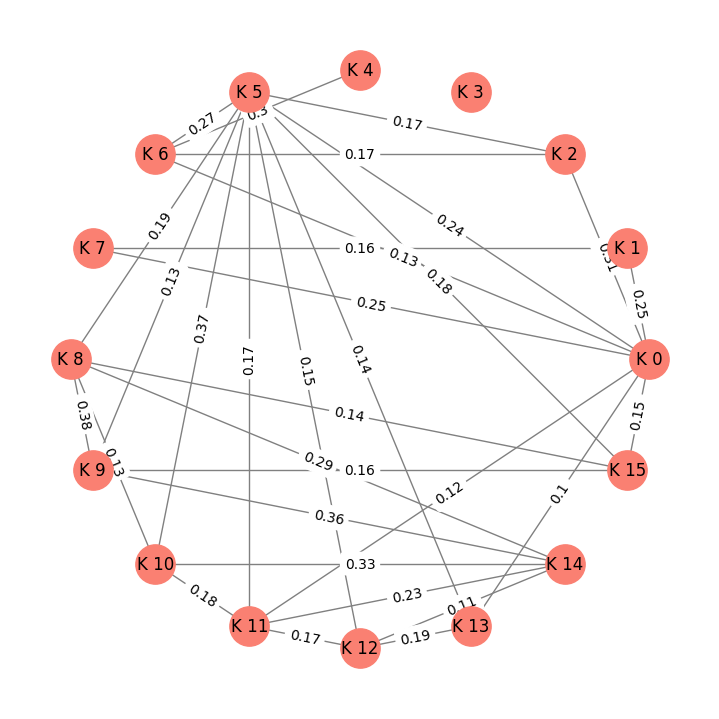

In [24]:
G_preprocessing = nx.Graph()

for i in range(len(cosine_sim_preprocessing)):
    G_preprocessing.add_node(i)

for i in range(len(cosine_sim_preprocessing)):
    for j in range(len(cosine_sim_preprocessing)):
        similarity = cosine_sim_preprocessing[i][j]
        if similarity > 0.1 and i != j:
            G_preprocessing.add_edge(i, j, weight=similarity)

pos = nx.circular_layout(G_preprocessing)

labels = {i: f'K {i}' for i in G_preprocessing.nodes()}

edge_labels = {(i, j): round(data['weight'], 2) for i, j, data in G_preprocessing.edges(data=True)}

node_size = 800

node_color = 'salmon'
edge_color = 'gray'

plt.figure(figsize=(7, 7))
nx.draw(G_preprocessing, pos, with_labels=True, labels=labels, node_size=node_size, node_color=node_color, edge_color=edge_color)
nx.draw_networkx_edge_labels(G_preprocessing, pos, edge_labels=edge_labels)
plt.show()


## Closeness

Menghitung dan menganalisis Closeness Centrality pada graf G_preprocessing.
Rumus Perhitungan Closeness Centrality:



In [25]:
# Menghitung closeness centrality
closeness_centrality_preprocessing = nx.closeness_centrality(G_preprocessing)

# Membuat DataFrame dari nilai Closeness Centrality
centrality_df_preprocessing = pd.DataFrame(closeness_centrality_preprocessing.items(), columns=['Node', 'Closeness Centrality Preprocessing'])

# Mengurutkan DataFrame berdasarkan Closeness Centrality dari yang terbesar
centrality_df_sorted_preprocessing = centrality_df_preprocessing.sort_values(by='Closeness Centrality Preprocessing', ascending=False)

# Menampilkan tabel Closeness Centrality yang telah diurutkan
centrality_df_sorted_preprocessing

,Node,Closeness Centrality Preprocessing
5,5,0.725926
0,0,0.653333
11,11,0.544444
6,6,0.522667
15,15,0.522667
13,13,0.502564
8,8,0.502564
2,2,0.502564
10,10,0.483951
9,9,0.483951


### Hasil penggunaan Closeness

In [26]:
# Mengambil tiga baris teratas dari DataFrame yang sudah diurutkan
top_three_closeness_preprocessing = centrality_df_sorted_preprocessing.head(3)

# Mendapatkan indeks node dari tiga baris teratas
top_node_indices_preprocessing = top_three_closeness_preprocessing['Node']

# Menampilkan kalimat yang sesuai dengan node-node teratas
for node_index in top_node_indices_preprocessing:
    print(f"Node Node Preprocessing {node_index}: {kalimat[node_index]}")

Node Node Preprocessing 5: Nazaruddin juga menilai pernyataan anggota DPR RI Fraksi Partai Nasdem Ahmad Sahroni, juga melanggar etik karena menyebut pihak yang mengusulkan DPR RI dibubarkan "tolol".
Node Node Preprocessing 0: JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan Dewan (MKD) DPR RI Nazaruddin Dek Gam menyebut, tindakan sejumlah anggota dewan yang berjoget saat masyarakat sedang susah melanggar etik.
Node Node Preprocessing 11: Lalu, Wakil Ketua DPR RI, Adis Kadir dari Fraksi Golkar, juga dinilai perlu dinonaktifkan.


##  Menghitung peringkat halaman dengan Pagerank
Rumus Perhitungan Manual PageRank:


*   PageRank mengukur pentingnya suatu node dalam sebuah graf berdasarkan seberapa banyak node lain yang mengarah ke node tersebut. Rumusnya adalah sebagai berikut:
$$PR(x) = (1 - d) + d \left( \frac{{L(y)}}{{PR(y)}} \right)$$
*   PR(x) adalah PageRank dari node x.
*   d adalah faktor damping, biasanya diatur sebagai 0,85.
*   PR(y) adalah PageRank dari node yang memiliki tautan ke node y.
*   L(y) adalah jumlah tautan keluar dari node y.
*   Iterasi dilakukan hingga konvergensi atau sejumlah iterasi tertentu. Semakin tinggi nilai PageRank, semakin "penting" node tersebut dalam graf.







In [27]:
# Menghitung closeness centrality
pagerank_preprocessing = nx.pagerank(G_preprocessing)

# Membuat DataFrame dari nilai Closeness Centrality
pagerank_df_preprocessing = pd.DataFrame(pagerank_preprocessing.items(), columns=['Node', 'Page Rank Preprocessing'])

# Mengurutkan DataFrame berdasarkan Closeness Centrality dari yang terbesar
pagerank_df_sorted_preprocessing = pagerank_df_preprocessing.sort_values(by='Page Rank Preprocessing', ascending=False)

# Menampilkan tabel Closeness Centrality yang telah diurutkan
pagerank_df_sorted_preprocessing

,Node,Page Rank Preprocessing
5,5,0.138230
0,0,0.119769
14,14,0.087345
8,8,0.075621
6,6,0.072306
9,9,0.069994
10,10,0.067937
11,11,0.061935
2,2,0.052047
12,12,0.049139


### Hasil Pagerank

In [28]:
# Mengambil tiga baris teratas dari DataFrame yang sudah diurutkan
top_three_pagerank_preprocessing = pagerank_df_sorted_preprocessing.head(3)

# Mendapatkan indeks node dari tiga baris teratas
top_node_indices = top_three_pagerank_preprocessing['Node']

# Menampilkan kalimat yang sesuai dengan node-node teratas
for node_index in top_node_indices:
    print(f"Node {node_index}: {kalimat[node_index]}")

Node 5: Nazaruddin juga menilai pernyataan anggota DPR RI Fraksi Partai Nasdem Ahmad Sahroni, juga melanggar etik karena menyebut pihak yang mengusulkan DPR RI dibubarkan "tolol".
Node 0: JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan Dewan (MKD) DPR RI Nazaruddin Dek Gam menyebut, tindakan sejumlah anggota dewan yang berjoget saat masyarakat sedang susah melanggar etik.
Node 14: "Uya Kuya, Eko, Sahroni, Nafa Urbach, Adis Kadir.


## menggunakan metode eigenvector centrality untuk menghitung sentralitas eigenvector pada graf
Rumus Perhitungan Manual Eigenvector Centrality:
*   Eigenvector Centrality mengukur pentingnya suatu node dalam suatu graf berdasarkan pada seberapa banyak node lain yang terhubung ke node tersebut. Rumusnya adalah sebagai berikut:
$$x_i = \frac{1}{\lambda} \sum_{j=1}^{n} A_{ij} x_j$$

* xi adalah eigenvector centrality dari node i
* Aij adalah elemen matriks ketetanggaan yang menunjukkan apakah ada tautan antara node i dan j
*   λ adalah nilai eigen (eigenvalue) yang sesuai dengan eigenvector yang dicari.
*   Iterasi dilakukan hingga konvergensi atau sejumlah iterasi tertentu. Semakin tinggi nilai eigenvector centrality, semakin "penting" node tersebut dalam graf.







In [29]:
# Menghitung closeness centrality
eigenvector_preprocessing = nx.eigenvector_centrality(G_preprocessing)
# Membuat DataFrame dari nilai Closeness Centrality
eigenvector_df_preprocessing = pd.DataFrame(eigenvector_preprocessing.items(), columns=['Node', 'Eigen Vector Preprocessing'])
# Mengurutkan DataFrame berdasarkan Closeness Centrality dari yang terbesar
eigenvector_df_sorted_preprocessing = eigenvector_df_preprocessing.sort_values(by='Eigen Vector Preprocessing', ascending=False)
# Menampilkan tabel Closeness Centrality yang telah diurutkan
eigenvector_df_sorted_preprocessing

,Node,Eigen Vector Preprocessing
5,5,4.902206e-01
0,0,3.510606e-01
11,11,3.043780e-01
8,8,2.891445e-01
15,15,2.634036e-01
10,10,2.559183e-01
14,14,2.556008e-01
9,9,2.480891e-01
12,12,2.401537e-01
13,13,2.066386e-01


### Hasil eigen vector

In [30]:
# Mengambil tiga baris teratas dari DataFrame yang sudah diurutkan
top_three_eigenvector_preprocessing = eigenvector_df_sorted_preprocessing.head(3)
# Mendapatkan indeks node dari tiga baris teratas
top_node_indices = top_three_eigenvector_preprocessing['Node']
# Menampilkan kalimat yang sesuai dengan node-node teratas
for node_index in top_node_indices:
    print(f"Node {node_index}: {kalimat[node_index]}")

Node 5: Nazaruddin juga menilai pernyataan anggota DPR RI Fraksi Partai Nasdem Ahmad Sahroni, juga melanggar etik karena menyebut pihak yang mengusulkan DPR RI dibubarkan "tolol".
Node 0: JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan Dewan (MKD) DPR RI Nazaruddin Dek Gam menyebut, tindakan sejumlah anggota dewan yang berjoget saat masyarakat sedang susah melanggar etik.
Node 11: Lalu, Wakil Ketua DPR RI, Adis Kadir dari Fraksi Golkar, juga dinilai perlu dinonaktifkan.


## Hasil ringkasan

3 kalimat teratas berdasarkan skor PageRank

In [31]:
# Mengambil 3 kalimat teratas berdasarkan PageRank
top_sentences_pagerank = pagerank_df_sorted_preprocessing.head(3)
top_indices_pagerank = top_sentences_pagerank['Node'].tolist()

# Mengurutkan indeks agar urutan kalimat sesuai dengan teks asli
top_indices_pagerank.sort()

# Menggabungkan kalimat-kalimat teratas menjadi ringkasan
summary = ' '.join([kalimat[i] for i in top_indices_pagerank])

print("--- Ringkasan Berita ---")
print(summary)

--- Ringkasan Berita ---
JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan Dewan (MKD) DPR RI Nazaruddin Dek Gam menyebut, tindakan sejumlah anggota dewan yang berjoget saat masyarakat sedang susah melanggar etik. Nazaruddin juga menilai pernyataan anggota DPR RI Fraksi Partai Nasdem Ahmad Sahroni, juga melanggar etik karena menyebut pihak yang mengusulkan DPR RI dibubarkan "tolol". "Uya Kuya, Eko, Sahroni, Nafa Urbach, Adis Kadir.


Ringkasan berita yang dihasilkan merupakan hasil dari proses peringkasan ekstraktif berbasis graf. Sistem secara otomatis menganalisis keseluruhan teks berita, kemudian memilih kalimat-kalimat yang memiliki skor kepentingan tertinggi berdasarkan algoritma PageRank.

Ringkasan yang Dihasilkan:

"JAKARTA, KOMPAS.com- Ketua Mahkamah Kehormatan Dewan (MKD) DPR RI Nazaruddin Dek Gam menyebut, tindakan sejumlah anggota dewan yang berjoget saat masyarakat sedang susah melanggar etik. Nazaruddin juga menilai pernyataan anggota DPR RI Fraksi Partai Nasdem Ahmad Sahroni, juga melanggar etik karena menyebut pihak yang mengusulkan DPR RI dibubarkan "tolol". "Uya Kuya, Eko, Sahroni, Nafa Urbach, Adis Kadir."

Analisis Hasil:
Ringkasan ini secara efektif menangkap inti dari artikel berita tersebut. Berikut adalah poin-poin utamanya:
*   Identifikasi Isu Utama: Algoritma berhasil mengidentifikasi bahwa topik sentral berita adalah tentang dugaan pelanggaran etik oleh anggota DPR RI.
*   Ekstraksi Poin Penting: Dua poin krusial berhasil diangkat: (1) kritik terhadap anggota dewan yang berjoget dan (2) kritik terhadap pernyataan Ahmad Sahroni.
*   Identifikasi Aktor Kunci: Sistem sukses mengekstrak nama-nama tokoh yang menjadi pusat perhatian dalam berita, seperti Nazaruddin Dek Gam (sebagai pemberi pernyataan) serta Ahmad Sahroni, Uya Kuya, dan lainnya (sebagai subjek berita).

Secara keseluruhan, hasil ini menunjukkan bahwa metode yang digunakan mampu menyaring dan menyajikan informasi paling relevan dari sebuah artikel, sehingga menghasilkan ringkasan yang padat dan informatif.






# Kesimpulan

Proyek ini mendemonstrasikan implementasi sistem peringkasan berita otomatis dari situs Kompas.com melalui pendekatan ekstraktif. Sistem ini dirancang untuk memproses sebuah artikel berita dan menghasilkan ringkasan yang berisi poin-poin informasi terpenting.

Metodologi yang Diterapkan:

Proses ini berjalan melalui beberapa tahapan komputasi linguistik dan analisis jaringan:



*   Web Scraping: Pengambilan data teks mentah dari satu artikel berita di Kompas.com menggunakan library requests dan BeautifulSoup.

*   Preprocessing Teks: Pembersihan teks dari data yang tidak relevan (angka, tanda baca) dan kata-kata umum (stopwords) untuk mempersiapkan analisis.

*   Vektorisasi & Kemiripan: Kalimat-kalimat diubah menjadi representasi numerik menggunakan TF-IDF, kemudian tingkat kemiripan antar kalimat dihitung menggunakan Cosine Similarity.

*   Analisis Graf (TextRank): Hubungan kemiripan antar kalimat dimodelkan sebagai sebuah graf. Kalimat yang paling penting (sentral) ditentukan dengan menghitung skor PageRank untuk setiap kalimat/node.
*   Generasi Ringkasan: Kalimat-kalimat dengan skor PageRank tertinggi dipilih dan digabungkan untuk membentuk ringkasan akhir.

Pencapaian:

Proyek ini berhasil membangun sebuah alur kerja (pipeline) end-to-end yang mampu mengubah data berita tidak terstruktur menjadi sebuah ringkasan yang ringkas dan informatif. Metode berbasis graf terbukti efektif dalam mengidentifikasi kalimat inti yang merepresentasikan keseluruhan isi berita.








